<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Function" data-toc-modified-id="Function-1">Function</a></span></li><li><span><a href="#Data-load-2021" data-toc-modified-id="Data-load-2021-2">Data load 2021</a></span><ul class="toc-item"><li><span><a href="#Scale" data-toc-modified-id="Scale-2.1">Scale</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.2">PCA</a></span></li><li><span><a href="#Find-optimal-k" data-toc-modified-id="Find-optimal-k-2.3">Find optimal k</a></span></li><li><span><a href="#Fit-model" data-toc-modified-id="Fit-model-2.4">Fit model</a></span></li></ul></li><li><span><a href="#Data-load-2020" data-toc-modified-id="Data-load-2020-3">Data load 2020</a></span><ul class="toc-item"><li><span><a href="#Scale" data-toc-modified-id="Scale-3.1">Scale</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3.2">PCA</a></span></li><li><span><a href="#Find-optimal-k" data-toc-modified-id="Find-optimal-k-3.3">Find optimal k</a></span></li><li><span><a href="#Fit-model" data-toc-modified-id="Fit-model-3.4">Fit model</a></span></li></ul></li><li><span><a href="#Remarks" data-toc-modified-id="Remarks-4">Remarks</a></span></li><li><span><a href="#Ref" data-toc-modified-id="Ref-5">Ref</a></span></li></ul></div>

## Function

In [1]:
import jaydebeapi 
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math

In [2]:
# Connect to Impala query engine
conn = jaydebeapi.connect(
    "com.cloudera.impala.jdbc41.Driver",
    "jdbc:impala://host:port/;AuthMech=1;KrbRealm=;KrbHostFQDN=impala-proxy;KrbServiceName=impala;REQUEST_POOL='root.tmp'",
    {},
    'D:/ImpalaJDBC41.jar'
    )
curs = conn.cursor()

In [3]:
def fetch_data(curs, query, mode = 'df'):
    curs.execute(query)
    df = curs.fetchall()
    if mode == 'raw': return df
    if mode == 'df':
        column_name = [i[0] for i in curs.description]
        df = pd.DataFrame(df, columns=column_name)
        return df

In [7]:
def plot_multiples(df, cols, ncols = 3):
    nrows = math.ceil(len(cols)/ncols)
    x, y = [0,0]
    if len(cols) <= 3:
        fig, axes = plt.subplots(1, len(cols), figsize = (18, 3))
        for i, col in enumerate(cols):
            sns.histplot(df[col], bins = 100, ax = axes[i])
    elif len(cols) > 2:
        fig, axes = plt.subplots(nrows, ncols, figsize = (18, nrows*3))
        for c, col in enumerate(cols):
            if c!= 0 and (c+1)%ncols == 1:
                x = x+1
                y = 0
            sns.histplot(df[col], bins = 100, ax = axes[x][y])
            y = y+1
        plt.tight_layout()

## Data load 2021
- select all customer with join_date in 2021
- schema: 
    - customer_id
    - recency (day from each customer's last order to now())
    - frequency (total number of orders of each customer)
    - monetary (total revenue from all orders of each customer)

In [6]:
df_2021 = fetch_data(curs, """select * from test.rfm where year(join_date) = 2021""")

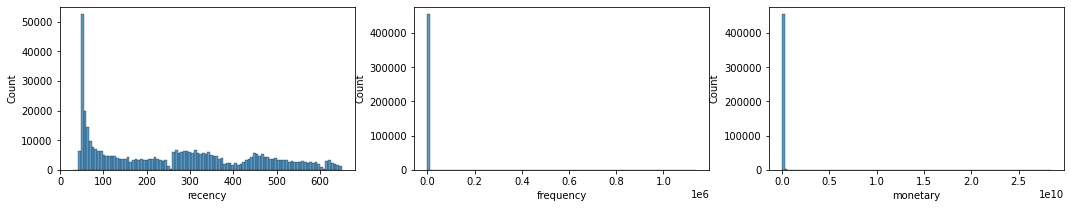

In [9]:
plot_multiples(df_2021, ['recency', 'frequency','monetary'])

### Scale
- using robust scaler to avoid outliers' effect

In [12]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(quantile_range=(0, 90))
df_scale = pd.DataFrame(
    scaler.fit_transform(df_2021[['recency', 'frequency','monetary']]),
    columns = ['scale_recency', 'scale_frequency','scale_monetary'],
)
df_scale.head(3)

,scale_recency,scale_frequency,scale_monetary
0,-0.433468,0.263566,0.243934
1,0.709677,-0.046512,-0.044911
2,-0.429435,12.333333,7.835028


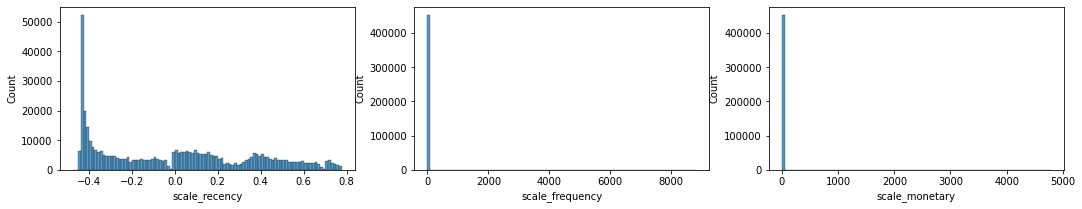

In [13]:
plot_multiples(df_scale, df_scale.columns)

### PCA

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_scale)

df_pca = pd.DataFrame(pca.transform(df_scale), columns=['first_pc', 'second_pc'], index=df_scale.index)
df_pca.head(3)

,first_pc,second_pc
0,-1.488461,-0.103164
1,-1.900061,-0.227696
2,12.744871,0.742676


### Find optimal k

In [15]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = df_pca

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

Text(0.5, 1.0, 'The Elbow Method using Inertia')

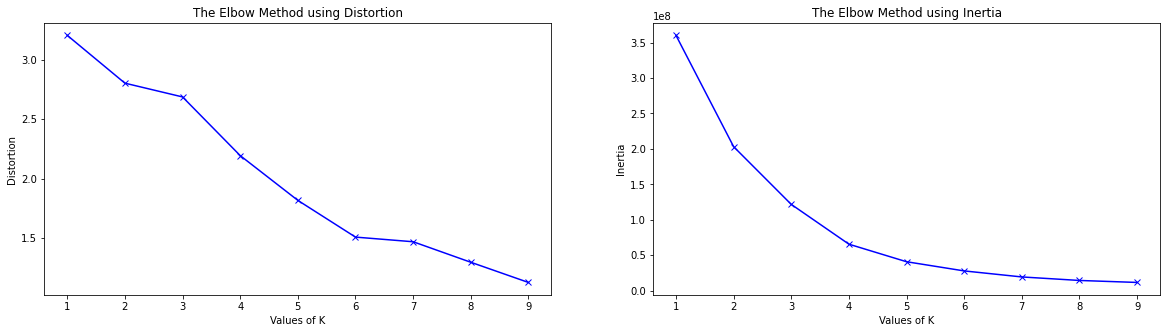

In [16]:
fig, axes = plt.subplots(1,2, figsize = (20,5))
# for key, val in mapping1.items():
#     print(f'{key} : {val}')
axes[0].plot(K, distortions, 'bx-')
axes[0].set_xlabel('Values of K')
axes[0].set_ylabel('Distortion')
axes[0].set_title('The Elbow Method using Distortion')
axes[1].plot(K, inertias, 'bx-')
axes[1].set_xlabel('Values of K')
axes[1].set_ylabel('Inertia')
axes[1].set_title('The Elbow Method using Inertia')

### Fit model

In [23]:
model = KMeans(n_clusters=6, random_state=42, max_iter = 1000)
model.fit(df_pca)
model.labels_.shape
df_pca["Cluster"] = model.labels_
df_2021["Cluster"] = model.labels_
# df_pca.groupby('Cluster').agg({
#     'recency':'mean',
#     'frequency':'mean',
#     'monetary':['mean', 'count']}).round(1)

<AxesSubplot:xlabel='monetary', ylabel='frequency'>

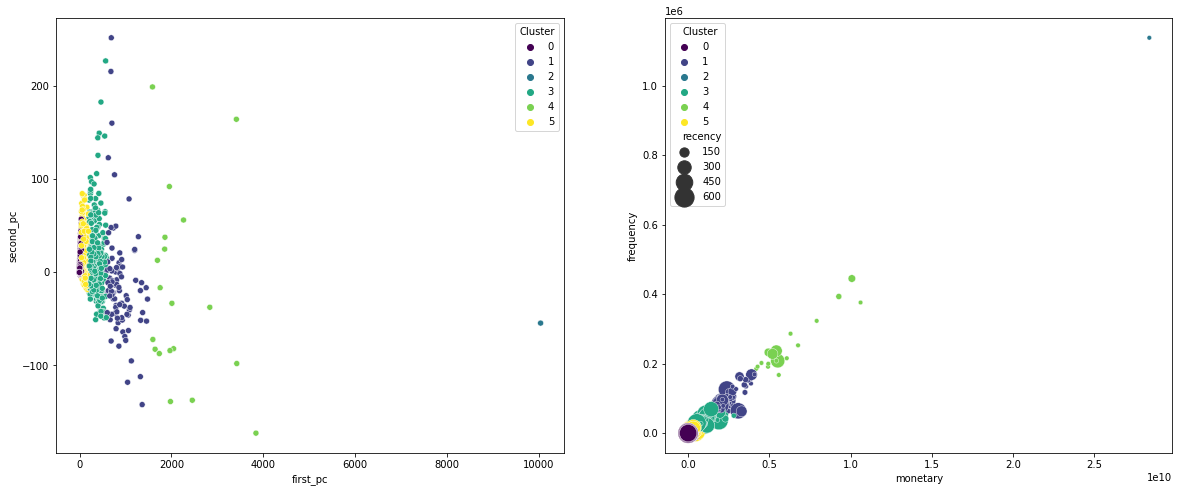

In [24]:
fig, axes = plt.subplots(1, 2 ,figsize=(20,8))
sns.scatterplot(data = df_pca, x='first_pc', y = 'second_pc', hue = 'Cluster', 
                palette="viridis", ax = axes[0])
sns.scatterplot(data = df_2021, x='monetary', y = 'frequency', size = 'recency',  hue = 'Cluster', sizes=(10, 400), 
                palette="viridis", ax = axes[1])

<AxesSubplot:xlabel='monetary', ylabel='frequency'>

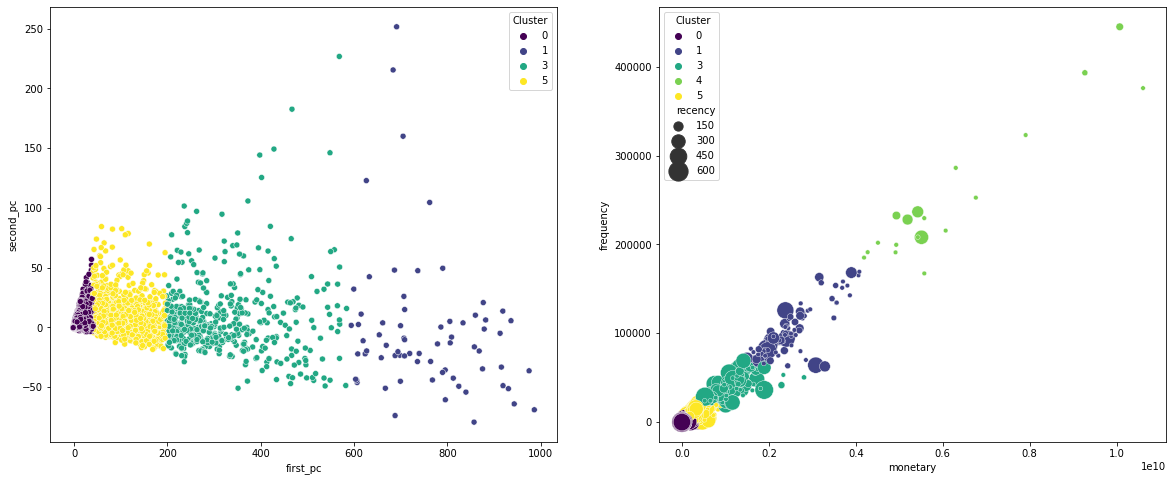

In [25]:
fig, axes = plt.subplots(1, 2 ,figsize=(20,8))
sns.scatterplot(data = df_pca.query('first_pc < 1000'), x='first_pc', y = 'second_pc', hue = 'Cluster', 
                palette="viridis", ax = axes[0])
sns.scatterplot(data = df_2021.query('frequency < 1000000'), x='monetary', y = 'frequency', size = 'recency',  hue = 'Cluster', sizes=(10, 400), 
                palette="viridis", ax = axes[1])

## Data load 2020

In [26]:
df_2020 = fetch_data(curs, """select * from test.rfm where year(join_date) = 2020""")

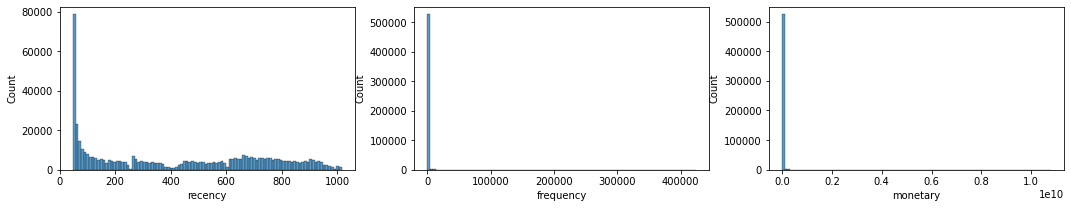

In [30]:
plot_multiples(df_2020, ['recency', 'frequency','monetary'])

### Scale

In [29]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(quantile_range=(0, 90))
df_scale = pd.DataFrame(
    scaler.fit_transform(df_2020[['recency', 'frequency','monetary']]),
    columns = ['scale_recency', 'scale_frequency','scale_monetary'],
)
df_scale.head(3)

,scale_recency,scale_frequency,scale_monetary
0,-0.414907,0.075269,0.090940
1,-0.349068,-0.043011,-0.041427
2,0.385093,-0.035842,-0.042872


### PCA

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_scale)

df_pca = pd.DataFrame(pca.transform(df_scale), columns=['first_pc', 'second_pc'], index=df_scale.index)
df_pca.head(3)

,first_pc,second_pc
0,-1.185636,-0.069416
1,-1.358294,-0.112548
2,-1.354722,-0.132913


### Find optimal k

Text(0.5, 1.0, 'The Elbow Method using Inertia')

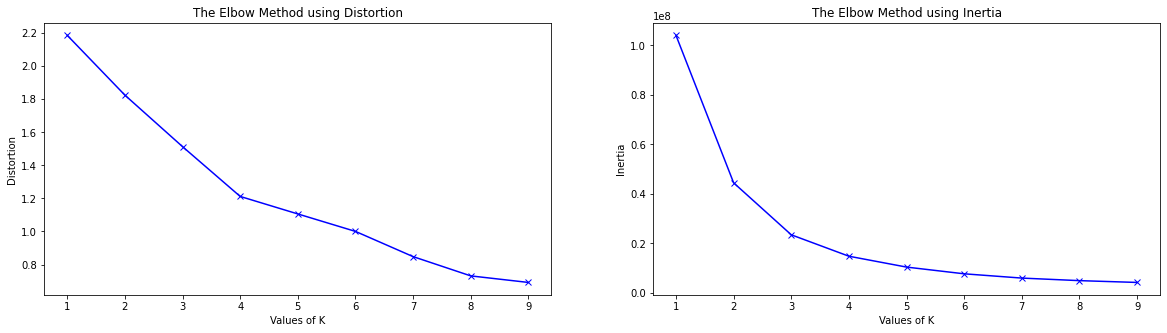

In [32]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = df_pca

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

fig, axes = plt.subplots(1,2, figsize = (20,5))
# for key, val in mapping1.items():
#     print(f'{key} : {val}')
axes[0].plot(K, distortions, 'bx-')
axes[0].set_xlabel('Values of K')
axes[0].set_ylabel('Distortion')
axes[0].set_title('The Elbow Method using Distortion')
axes[1].plot(K, inertias, 'bx-')
axes[1].set_xlabel('Values of K')
axes[1].set_ylabel('Inertia')
axes[1].set_title('The Elbow Method using Inertia')

### Fit model

<AxesSubplot:xlabel='monetary', ylabel='frequency'>

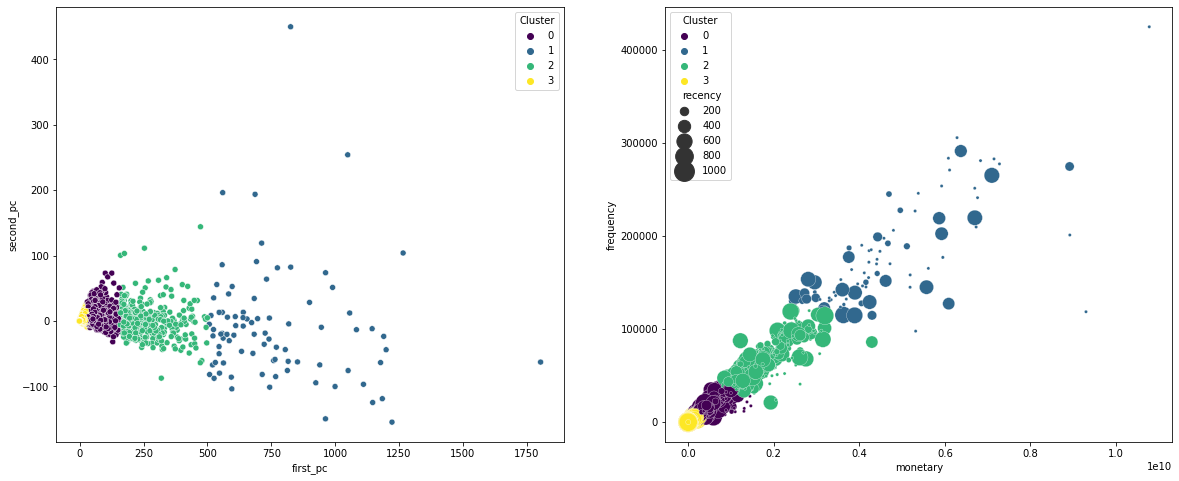

In [33]:
model = KMeans(n_clusters=4, random_state=42, max_iter = 1000)
model.fit(df_pca)
model.labels_.shape
df_pca["Cluster"] = model.labels_
df_2020["Cluster"] = model.labels_
fig, axes = plt.subplots(1, 2 ,figsize=(20,8))
sns.scatterplot(data = df_pca, x='first_pc', y = 'second_pc', hue = 'Cluster', 
                palette="viridis", ax = axes[0])
sns.scatterplot(data = df_2020, x='monetary', y = 'frequency', size = 'recency',  hue = 'Cluster', sizes=(10, 400), 
                palette="viridis", ax = axes[1])

## Remarks
based on results and visualization:
- frequency and monetary are dominant, recency has no impact in clustering
- it seems that rfm segmentation is not as suitable for lastmile e-logistic (because revenue, basically shipping fee, is nearly the same among all orders, so frequency and monetary value is highly correlated) as for e-commerce (where frequency and monetary value make more sense in segmentation, because value of each order varies)
- futher examination is needed to verify the above remark

## Ref
- rfm with k-clustering: https://medium.com/@melodyyip515_/rfm-customer-segmentation-using-python-1a1865c6e7cb
- feature scaling: 
    - https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35
    - https://www.kaggle.com/code/alexisbcook/scaling-and-normalization
- when log transformation: https://stats.stackexchange.com/questions/18844/when-and-why-should-you-take-the-log-of-a-distribution-of-numbers